In [1]:
import pandas as pd
import numpy as np
import os

from scipy.stats import skew, kurtosis
from scipy.fft import fft
from sklearn.preprocessing import RobustScaler

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score 
from sklearn.manifold import TSNE


from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier




# Copy of DataUtils Class from 4.Pipeline_ML_ScikitLearn.ipynb

In [2]:



class DataUtils():
    #---------------------------------------------
    #Load a file and returns it as a list
    #---------------------------------------------
    @staticmethod
    def loadFile(abs_path_to_file):
        """Load a .npy file."""
        obs=np.load(abs_path_to_file)
        return obs
    
    @staticmethod
    def extract_features_from_lst(meas_lst, label=""):
        fs=50000
        fft_coeffs = np.abs(fft(meas_lst))
        freq= np.fft.fftfreq(len(meas_lst), d=1 / fs)
        maxIdx = np.argmax(fft_coeffs[freq>=0])
        max_amplitude = fft_coeffs[maxIdx]
        dominant_frequency = freq[maxIdx]
        meas_lst=np.array(meas_lst, dtype=np.int64)
        return {
            f'mean_{label}': np.mean(meas_lst),
            f'std_{label}': np.std(meas_lst),
            f'min_{label}': np.min(meas_lst),
            f'max_{label}': np.max(meas_lst),
            f'energy_{label}': np.sum(np.square(meas_lst)),
            f'rootMeanSquare_{label}': np.sqrt(np.mean(np.square(meas_lst))),
            f'skewness_{label}': skew(meas_lst),
            f'kurtosis_{label}': kurtosis(meas_lst),
            f'fft_peak_amplitude_{label}': max_amplitude,
            f'fft_peak_frequency_{label}': dominant_frequency
        }
    @staticmethod
    def TrainTestFeaturesExtraction(df, fold, measType, mainDir):
        y_train=df[(df['Fold']==fold) & (df['Type']=="Train") ]['LabelIDs']
        x_train_files=df[(df['Fold']==fold) & (df['Type']=="Train") ]['FilePath']
        y_test=df[(df['Fold']==fold) & (df['Type']=="Test" )]['LabelIDs']
        x_test_files=df[(df['Fold']==fold) & (df['Type']=="Test") ]['FilePath']
        x_train_features=pd.DataFrame()
        x_test_features=pd.DataFrame()
        for files in x_train_files:
            array=np.transpose(DataUtils.loadFile(os.path.join(mainDir, files)))
            x_train_dict={}
            for i in range(0, len(array)):
                x_train_dict.update(DataUtils.extract_features_from_lst(array[:, i], label=measType[i]))
    
            x_train_features=pd.concat([x_train_features, pd.DataFrame([x_train_dict])], ignore_index=True)
    
        for files in x_test_files:
            array=np.transpose(DataUtils.loadFile(os.path.join(mainDir, files)))
            x_test_dict={}
            for i in range(0, len(array)):
                x_test_dict.update(DataUtils.extract_features_from_lst(array[:, i], label=measType[i]))
    
            x_test_features=pd.concat([x_test_features, pd.DataFrame([x_test_dict])], ignore_index=True)
        return x_train_features, x_test_features, y_train, y_test

    @staticmethod
     # Évaluation du modèle
    def model_evaluation(y_test, y_pred):
        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)  # Dictionnaire contenant Precision, Recall, F1-score
        report_df=pd.DataFrame(report).transpose()
       
        conf_matrix = confusion_matrix(y_test, y_pred)  # Matrice de confusion
    
        return report_df, conf_matrix
    @staticmethod
    def padTruncate(mySig, maxTime, fs):
        """Pad or truncate the data to have a fixed duration.
        Args:
            mySig: the signal as a list
            maxTime: The maximum time in milliseconds.
            fs: the sampling rate in Hz    
            """
        sLen = mySig.shape[0]
        trunc=0
        maxLen=int(maxTime*int(fs/1000))
        if sLen > maxLen:
            trunc=1
            mySig = mySig[:, :maxLen]
        elif sLen < maxLen:
            trunc=-1
            mySig = np.pad(mySig, ((0, maxLen - sLen),(0,0)), mode='wrap')
        
        return (trunc, len(mySig), mySig)

# Functions for PCA and Random Forest applied to our particular dataset

In [3]:


def x_loading_pading(subsetXTrainFiles, myDir):
    #Takes a list of files and returns a numpy array of shape (nObservations, nChannels, nSamples)
    X_subset=[]
    
    for file in subsetXTrainFiles:    
        myArray=np.load(os.path.join(myDir, file))
        
        #align size of files to standard size of 250062 samples
        myArray=np.transpose(DataUtils.padTruncate(myArray, maxTime=5001.24, fs=50000)[2])
        X_subset.append(myArray)
    X_subset=np.array(X_subset) #X_subset.shape (1989 observations, 4 channels :sound, accel X,Y,Z, 250062 samples per observation)
    
    return X_subset

def fit_scalers(X_train):
    """
    Initialise et entraîne des RobustScaler pour chaque canal à partir des données Train.
    Retourne une liste de scalers.
    """
    nChannels = X_train.shape[1]
    scalers = [RobustScaler() for _ in range(nChannels)]
    
    for ch in range(nChannels):
        X_train[:, ch, :] = scalers[ch].fit_transform(X_train[:, ch, :])  # Fit + transform sur Train
    
    return scalers, X_train  # Retourne les scalers et les données scalées

def apply_scaling(X_test, scalers):
    """
    Applique les scalers appris sur Train aux données de Test.
    Retourne les données Test scalées.
    """
    X_test_scaled = np.copy(X_test)  # Éviter de modifier les données originales
    nChannels = X_test.shape[1]
    
    for ch in range(nChannels):
        X_test_scaled[:, ch, :] = scalers[ch].transform(X_test_scaled[:, ch, :])  # Seulement transform
    
    return X_test_scaled

def pca_fitting(n_max_pca, x_scaled, meas_type=['Sound', 'AccelX', 'AccelY', 'AccelZ']):
    # n_pca_max : maximum number of PCA components
    # X_scaled : scaled data of shape (nObservations, nChannels, nSamples)
    #return pca_models which is a list of PCA models, one per channel ready to be fitted
    n_channels=x_scaled.shape[1]
    pca_models = [PCA(n_components=n_max_pca) for _ in range(n_channels)]
    for ch in range(n_channels):
        print(f"PCA on Channels {meas_type[ch]}...")
        pca_models[ch].fit(x_scaled[:, ch, :]) # Fit PCA on each channel
    return pca_models


def pca_transforming(X_scaled, pca_models, channels=4, n_pca_components=100):
    # X_scaled : scaled data of shape (nObservations, nChannels, nSamples)
    # pca_models : list of PCA models, one per channel
    # channels : number of channels
    # n_pca_components : number of PCA components
    X_tot_pca = np.zeros((len(X_scaled), channels, n_pca_components), dtype=np.float32)  # Shape (1989, 4, 100)
    
    # Iterate over each observation in the subset
    for obs_idx, observation in enumerate(X_scaled):
        # Here 'observation' is a ndarray with shape (nChannel, nSamples)
        X_pca = np.zeros((channels, pca_models[0].components_.shape[0]), dtype=np.float32)  # (4, 50)
        # Itération sur chaque canal dans l'observation (axe 1)
        for chan_idx, channel in enumerate(observation):
            #Channel contains nSamples samples
            X_pca[chan_idx, :] = pca_models[chan_idx].transform(channel.reshape(1,-1))  # Application PCA
        
        X_tot_pca[obs_idx, :, :] = X_pca[:, :n_pca_components] 
    return X_tot_pca



# Import Metadata DataFrame

In [4]:
myNpy="F:/Data_BachelorHES/5.Dataset_preparation/3.TrainsetBalancing/GlobalFoldsFiles_Train_Test_Augmented_Cleaned.csv"
myGlobalDs=pd.read_csv(myNpy)
myGlobalDs.drop(myGlobalDs.columns[myGlobalDs.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
del myNpy

# PCA for One Fold - Tuning the number of PCA components
- Visualize the variance ratio

PCA on Channels Sound...
PCA on Channels AccelX...
PCA on Channels AccelY...
PCA on Channels AccelZ...


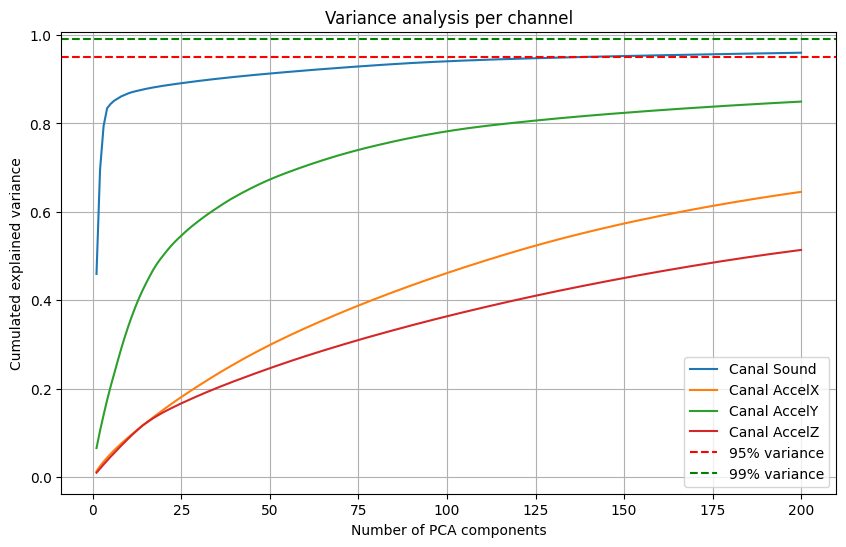

In [6]:

myDir="F:/Data_BachelorHES/5.Dataset_preparation/3.TrainsetBalancing"
fold=0
measType=['Sound', 'AccelX', 'AccelY', 'AccelZ']
subsetXFiles=myGlobalDs[(myGlobalDs['Fold']==fold) & (myGlobalDs['Type']=="Train") ]['FilePath'].copy()


#Loading and Scaling
X_train=x_loading_pading(subsetXFiles, myDir)
scalers, X_scaled=fit_scalers(X_train) 

#Models fitting
n_pca_max=200
pca_models=pca_fitting(n_pca_max, X_scaled)

# Concatenate of statistics and PCA components
nChannels=4
explained_variance_ratios = []
for ch in range(nChannels):
    explained_variance_ratios.append(np.cumsum(pca_models[ch].explained_variance_ratio_))  # cumulated variance ratio

#Trace variance ratio for each channel
plt.figure(figsize=(10, 6))
for ch in range(nChannels):
    plt.plot(range(1, n_pca_max+1), explained_variance_ratios[ch], label=f"Canal {measType[ch]}")

plt.axhline(y=0.95, color='r', linestyle='--', label="95% variance")
plt.axhline(y=0.99, color='g', linestyle='--', label="99% variance")
plt.xlabel("Number of PCA components")
plt.ylabel("Cumulated explained variance")
plt.title("Variance analysis per channel")
plt.legend()
plt.grid()
plt.show()
del myDir, fold, subsetXFiles, X_train, scalers, X_scaled, n_pca_max, pca_models, nChannels, ch


In [7]:
for i,ch in enumerate(explained_variance_ratios):
    print(f"Channel {measType[i]} explains : {ch[49]*100:.2f}% of variance with 50 components")
    
for i,ch in enumerate(explained_variance_ratios):
    print(f"Channel {measType[i]} explains : {ch[99]*100:.2f}% of variance with 100 components")
    
for i,ch in enumerate(explained_variance_ratios):
    print(f"Channel {measType[i]} explains : {ch[199]*100:.2f}% of variance with 200 components")
    
del i, ch, measType, explained_variance_ratios

Channel Sound explains : 91.30% of variance with 50 components
Channel AccelX explains : 29.92% of variance with 50 components
Channel AccelY explains : 67.34% of variance with 50 components
Channel AccelZ explains : 24.66% of variance with 50 components
Channel Sound explains : 94.06% of variance with 100 components
Channel AccelX explains : 46.17% of variance with 100 components
Channel AccelY explains : 78.22% of variance with 100 components
Channel AccelZ explains : 36.40% of variance with 100 components
Channel Sound explains : 96.00% of variance with 200 components
Channel AccelX explains : 64.53% of variance with 200 components
Channel AccelY explains : 84.95% of variance with 200 components
Channel AccelZ explains : 51.39% of variance with 200 components


- Visualize the features in 2D with t-SNE

In [8]:
# Concaténation des statistiques et des composantes PCA
# pca_models - 4 pca models, 1 for each channel already fitted
myDir="F:/Data_BachelorHES/5.Dataset_preparation/3.TrainsetBalancing"
fold=0
measType=['Sound', 'AccelX', 'AccelY', 'AccelZ']
n_pca_max=100
scaler=RobustScaler()

#Load the statistical features (i.e. 40 features per observation)
x_train_features, _, y_train, __ = DataUtils.TrainTestFeaturesExtraction(myGlobalDs, fold, measType, myDir) # (1989, 40)
X_train_scaled=scaler.fit_transform(x_train_features)

#Loading and Scaling
subsetXFiles=myGlobalDs[(myGlobalDs['Fold']==fold) & (myGlobalDs['Type']=="Train") ]['FilePath'].copy()
X_train=x_loading_pading(subsetXFiles, myDir)
scalers, X_scaled=fit_scalers(X_train) #X_scaled (1989, 4, 250000) 

#PCA fit (find eignevectors) -> tranform (apply eigenvectors to data)
pca_models=pca_fitting(n_pca_max, X_scaled)
X_tot_pca=pca_transforming(X_scaled, pca_models, channels=4, n_pca_components=100) #size is (1989, 4, 100)

# Flatten PCA data and concatenate with statistical features
x_pca_flatten = X_tot_pca.reshape(X_tot_pca.shape[0], -1)  # Flatten : (1989, 400)
x_tsne_input = np.hstack((X_train_scaled, x_pca_flatten))  # Shape : (1989, 440)

# Vérification de la shape finale
print("Shape des données pour t-SNE :", x_tsne_input.shape)  # (1989, 440)

del x_train_features, X_train_scaled, subsetXFiles, X_train, scalers, X_scaled, X_tot_pca, x_pca_flatten, scaler, pca_models, n_pca_max, fold, measType, myDir

PCA on Channels Sound...
PCA on Channels AccelX...
PCA on Channels AccelY...
PCA on Channels AccelZ...
Shape des données pour t-SNE : (1989, 440)


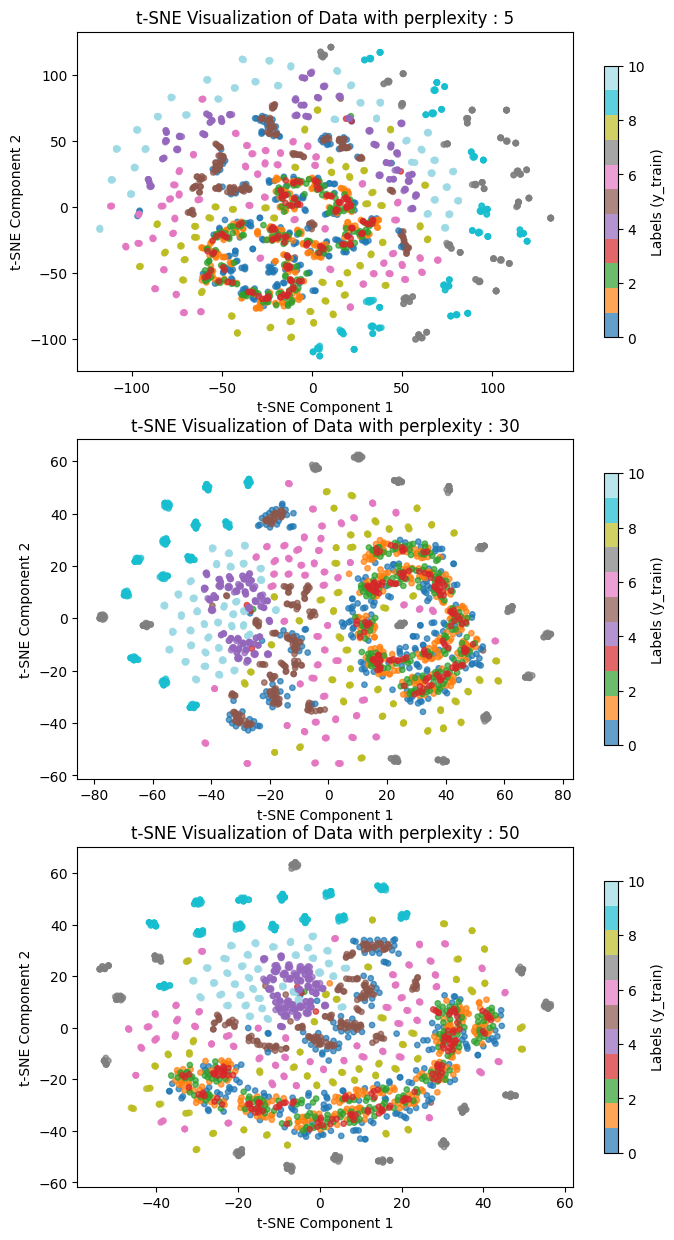

In [9]:

# Application de t-SNE
perp=[5, 30, 50]
# Prepare figure and subplots
fig, axes = plt.subplots(3, 1, figsize=(8, 15))  # 3 lines, 1 column
num_classes=y_train.value_counts().shape[0]
colormap = plt.get_cmap('tab20', num_classes) 
for i, p in enumerate(perp):
    tsne = TSNE(n_components=2, perplexity=p, max_iter=1000, random_state=42)
    x_tsne = tsne.fit_transform(x_tsne_input)  # Shape : (1989, 2)

    # Visualisation des résultats
    #plt.figure(figsize=(10, 8))
    scatter = axes[i].scatter(x_tsne[:, 0], x_tsne[:, 1], c=y_train, cmap=colormap, s=15, alpha=0.7)
    cbar = fig.colorbar(scatter, ax=axes[i], orientation="vertical", shrink=0.8)
    cbar.set_label("Labels (y_train)")

    axes[i].set_title(f"t-SNE Visualization of Data with perplexity : {p}")
    axes[i].set_xlabel("t-SNE Component 1")
    axes[i].set_ylabel("t-SNE Component 2")

#plt.tight_layout()
plt.show()

del x_tsne, x_tsne_input, scatter, cbar, fig, axes, colormap, num_classes, perp, tsne, i, p, y_train

# PCA ON FEATURES FOR ALL FOLDS

In [11]:

conf_matrices = []  # Liste pour stocker les matrices de confusion
report_dict = {}  # Dictionnaire pour stocker les rapports par fold

nFold=5
n_pca_max=100
scaler=RobustScaler()
measType=['Sound', 'AccelX', 'AccelY', 'AccelZ']
myDir="F:/Data_BachelorHES/5.Dataset_preparation/3.TrainsetBalancing"

for fold in range(nFold):
    
    
    print(f"Fold {(fold+1)}/{nFold} - Starting")
    #Loading of train files
    subsetXTrainFiles=myGlobalDs[(myGlobalDs['Fold']==fold) & (myGlobalDs['Type']=="Train") ]['FilePath'].copy()
 
    #Loading, Padding and Scaling 
    X_Train=x_loading_pading(subsetXTrainFiles, myDir)
    scalers, X_Train_scaled=fit_scalers(X_Train)
    print(f"Fold {(fold+1)}/{nFold} - scaling done")
    
    #Models fitting on train files
    pca_models=pca_fitting(n_pca_max, X_Train_scaled)
    
    #PCA transformation
    X_train_pca=pca_transforming(X_Train_scaled, pca_models, channels=4, n_pca_components=n_pca_max)
    del X_Train, X_Train_scaled, subsetXTrainFiles    
    #Loading of test files
    subsetXTestFiles = myGlobalDs[(myGlobalDs['Fold'] == fold) & (myGlobalDs['Type'] == "Test")]['FilePath'].copy()
    X_Test = x_loading_pading(subsetXTestFiles, myDir)

    # Apply scalers from Train on Test so only trnsform, no refit.
    X_Test_scaled = apply_scaling(X_Test, scalers)
    
    # PCA Transformation on Test
    X_test_pca = pca_transforming(X_Test_scaled, pca_models, channels=4, n_pca_components=n_pca_max)
    print(f"Fold {(fold+1)}/{nFold} - PCA Transformation done")
    del X_Test, X_Test_scaled, subsetXTestFiles, pca_models, scalers
    
    # Import of statistical features and scaling
    x_train_features, x_test_features, y_train, y_test = DataUtils.TrainTestFeaturesExtraction(myGlobalDs, fold, measType, myDir)
    X_stat_train_scaled=scaler.fit_transform(x_train_features)
    X_stat_test_scaled=scaler.transform(x_test_features)
    del x_train_features, x_test_features
    
    #Flattening of features 
    x_train_pca_flat = X_train_pca.reshape(X_train_pca.shape[0], -1)  # Flatten : (1989, 400)
    x_test_pca_flat = X_test_pca.reshape(X_test_pca.shape[0], -1)  # Flatten : (1989, 400)
    print(f"Fold {(fold+1)}/{nFold} - Flattening done")
    #Concatenate PCA and statistics
    X_train_combined = np.hstack((x_train_pca_flat, X_stat_train_scaled))  # (1989, 440)
    X_test_combined = np.hstack((x_test_pca_flat, X_stat_test_scaled))  # (test_size, 440)
    del x_train_pca_flat, x_test_pca_flat, X_stat_train_scaled, X_stat_test_scaled, X_train_pca, X_test_pca
    #Starting training of random forest
    print(f"Fold {(fold+1)}/{nFold} - Starting Random Forest")
    
    # Initialisation du modèle
    clf = RandomForestClassifier(n_estimators=100, random_state=42)

    # Entraînement du modèle
    clf.fit(X_train_combined, y_train)

    # Prédictions
    y_pred = clf.predict(X_test_combined)

    # Évaluation du modèle
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)  # Dictionnaire contenant Precision, Recall, F1-score
    report_df=pd.DataFrame(report).transpose()
    report_dict[f"Fold {fold}"]=report_df
    conf_matrix = confusion_matrix(y_test, y_pred)  # Matrice de confusion

    # 🔹 Stockage des résultats dans le DataFrame
    df_fold=pd.DataFrame([{
        "Fold": fold+1,
        "Accuracy": acc,
        "Precision": report["weighted avg"]["precision"],
        "Recall": report["weighted avg"]["recall"],
        "F1-score": report["weighted avg"]["f1-score"],
        "Support": report["weighted avg"]["support"]
    }])
    if fold==0:
        df_results=df_fold
    else:
        df_results=pd.concat([df_results, df_fold], ignore_index=True)

    conf_matrices.append(conf_matrix)  # Stocker la matrice de confusion pour analyse
    # Évaluation du modèle
    print("Accuracy :", acc)
    print("Report weighted average :", report["weighted avg"])
    del  X_train_combined, X_test_combined, y_pred, clf, df_fold, report, report_df, acc, conf_matrix
    

del nFold, fold, measType, myDir, n_pca_max, scaler, y_test, y_train

Fold 1/5 - Starting
Fold 1/5 - scaling done
PCA on Channels Sound...
PCA on Channels AccelX...
PCA on Channels AccelY...
PCA on Channels AccelZ...
Fold 1/5 - PCA Transformation done
Fold 1/5 - Flattening done
Fold 1/5 - Starting Random Forest
Accuracy : 0.6920980926430518
Report weighted average : {'precision': 0.746211689808397, 'recall': 0.6920980926430518, 'f1-score': 0.685802390137267, 'support': 367.0}
Fold 2/5 - Starting
Fold 2/5 - scaling done
PCA on Channels Sound...
PCA on Channels AccelX...
PCA on Channels AccelY...
PCA on Channels AccelZ...
Fold 2/5 - PCA Transformation done
Fold 2/5 - Flattening done
Fold 2/5 - Starting Random Forest
Accuracy : 0.6730245231607629
Report weighted average : {'precision': 0.7326709653915859, 'recall': 0.6730245231607629, 'f1-score': 0.6678621863533794, 'support': 367.0}
Fold 3/5 - Starting
Fold 3/5 - scaling done
PCA on Channels Sound...
PCA on Channels AccelX...
PCA on Channels AccelY...
PCA on Channels AccelZ...
Fold 3/5 - PCA Transformation

# Visualize the results of PCA


In [12]:
#Random Forest
# Concatenate all DataFrames and take the mean
df_mean = pd.concat(report_dict.values()).groupby(level=0).mean()
df_mean.index=["10_T02 M06 (VHM 309-12)  ", "11_T03 M06 (VHM 309-6)   ","9_T24 M06 (FRSURF50X5)   ","12_T06 M06 (VHM 309-3)   ", "13_T23 M06 (CHANF8)      ","3_T14 M06 (MECHE5.3)     ","4_T08 M06 (MECHE3.7 MD)  ","5_T09 M06 (MECHE4.6 MD)  ","6_T19 M06 (MECHE MD D4.8)","7_T10 M06 (MECHE5.5 MD)  ","8_T05 M06 (MECHE MD D5.8)", "accuracy", "macro avg", "weighted avg"]
print("Classification Report for Random Forest")
print(df_mean.sort_index())
del df_mean

Classification Report for Random Forest
                           precision    recall  f1-score     support
10_T02 M06 (VHM 309-12)     0.981783  0.676712  0.800896  146.000000
11_T03 M06 (VHM 309-6)      0.419729  0.691667  0.522206   48.000000
12_T06 M06 (VHM 309-3)      0.544545  0.763636  0.634272   44.000000
13_T23 M06 (CHANF8)         0.689515  0.731429  0.701808   35.000000
3_T14 M06 (MECHE5.3)        0.540000  1.000000  0.700138    9.000000
4_T08 M06 (MECHE3.7 MD)     0.717956  0.968889  0.822623   45.000000
5_T09 M06 (MECHE4.6 MD)     0.850000  0.200000  0.319706   13.000000
6_T19 M06 (MECHE MD D4.8)   0.000000  0.000000  0.000000    3.000000
7_T10 M06 (MECHE5.5 MD)     0.000000  0.000000  0.000000   12.000000
8_T05 M06 (MECHE MD D5.8)   0.600000  0.200000  0.300000    3.000000
9_T24 M06 (FRSURF50X5)      0.597778  0.355556  0.431697    9.000000
accuracy                    0.681744  0.681744  0.681744    0.681744
macro avg                   0.540119  0.507990  0.475759  367.0

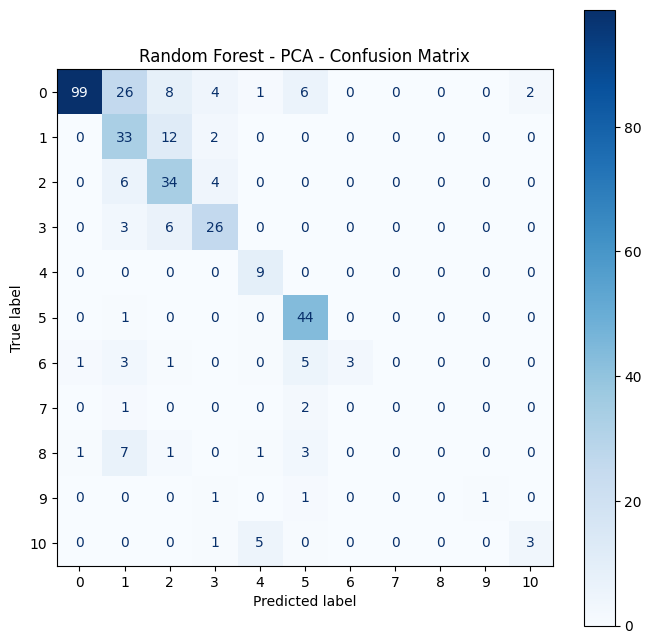

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt


def plot_confusion_matrix(matrix, title="Confusion Matrix"):
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
    fig, ax = plt.subplots(figsize=(8, 8))  # Ajuste la taille si nécessaire
    disp.plot(ax=ax, cmap="Blues", values_format=".0f")
    ax.set_title(title)
    plt.show()


sum_test = np.sum(conf_matrices, axis=0)
sum_test = sum_test / float(len(conf_matrices))
plot_confusion_matrix(sum_test, title="Random Forest - PCA - Confusion Matrix")

del sum_test

In [18]:
# save results
df_results.to_csv("F:/Data_BachelorHES/5.Dataset_preparation/5.ML_PCA_Results/Results_PCA_Compact.csv", index=False)


In [15]:
for i, matrix in enumerate(conf_matrices):
    df = pd.DataFrame(matrix)
    df.to_csv(f"F:/Data_BachelorHES/5.Dataset_preparation/5.ML_PCA_Results/confusion_matrix_PCA_fold_{i+1}.csv", index=False)
del i, matrix, df

In [16]:
for i, report in enumerate(report_dict):
    report_dict[report].to_csv(f"F:/Data_BachelorHES/5.Dataset_preparation/5.ML_PCA_Results/Reports_PCA_Fold_{i+1}.csv", index=True)
del i, report

              precision    recall  f1-score     support
0              0.979592  0.657534  0.786885  146.000000
1              0.383721  0.687500  0.492537   48.000000
2              0.642857  0.818182  0.720000   44.000000
3              0.743590  0.828571  0.783784   35.000000
4              0.450000  1.000000  0.620690    9.000000
5              0.745763  0.977778  0.846154   45.000000
6              1.000000  0.307692  0.470588   13.000000
7              0.000000  0.000000  0.000000    3.000000
8              0.000000  0.000000  0.000000   12.000000
9              1.000000  0.333333  0.500000    3.000000
10             0.500000  0.222222  0.307692    9.000000
accuracy       0.692098  0.692098  0.692098    0.692098
macro avg      0.585957  0.530256  0.502575  367.000000
weighted avg   0.746212  0.692098  0.685802  367.000000


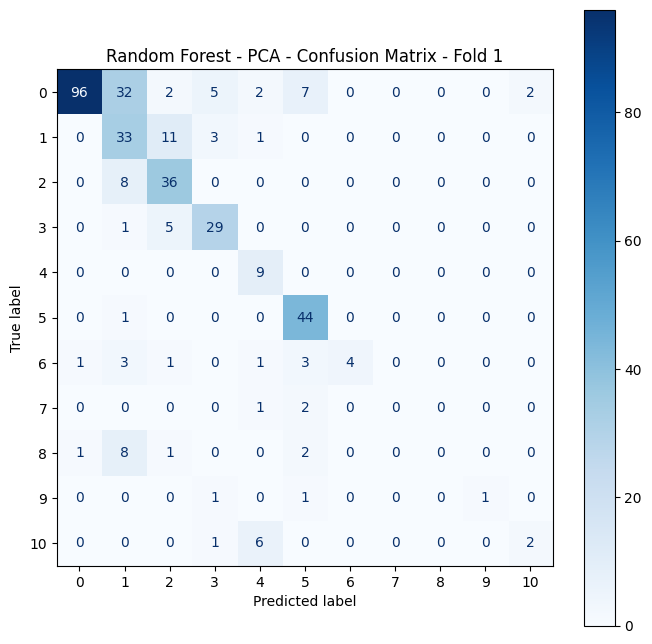

              precision    recall  f1-score     support
0              1.000000  0.684932  0.813008  146.000000
1              0.384615  0.625000  0.476190   48.000000
2              0.451613  0.636364  0.528302   44.000000
3              0.612245  0.857143  0.714286   35.000000
4              0.562500  1.000000  0.720000    9.000000
5              0.814815  0.977778  0.888889   45.000000
6              1.000000  0.153846  0.266667   13.000000
7              0.000000  0.000000  0.000000    3.000000
8              0.000000  0.000000  0.000000   12.000000
9              1.000000  0.333333  0.500000    3.000000
10             0.600000  0.333333  0.428571    9.000000
accuracy       0.673025  0.673025  0.673025    0.673025
macro avg      0.584163  0.509248  0.485083  367.000000
weighted avg   0.732671  0.673025  0.667862  367.000000


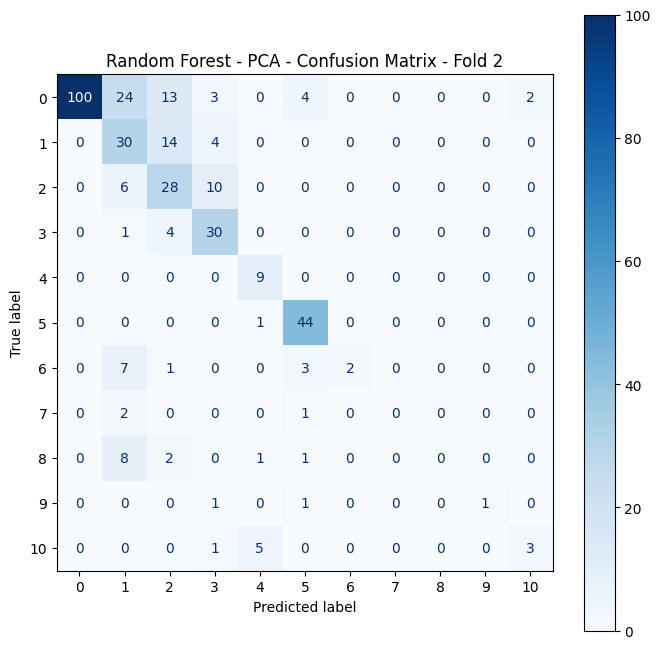

              precision    recall  f1-score     support
0              0.990476  0.712329  0.828685  146.000000
1              0.421053  0.666667  0.516129   48.000000
2              0.507042  0.818182  0.626087   44.000000
3              0.769231  0.571429  0.655738   35.000000
4              0.562500  1.000000  0.720000    9.000000
5              0.647059  0.977778  0.778761   45.000000
6              0.500000  0.076923  0.133333   13.000000
7              0.000000  0.000000  0.000000    3.000000
8              0.000000  0.000000  0.000000   12.000000
9              0.000000  0.000000  0.000000    3.000000
10             0.666667  0.222222  0.333333    9.000000
accuracy       0.675749  0.675749  0.675749    0.675749
macro avg      0.460366  0.458684  0.417461  367.000000
weighted avg   0.710445  0.675749  0.660813  367.000000


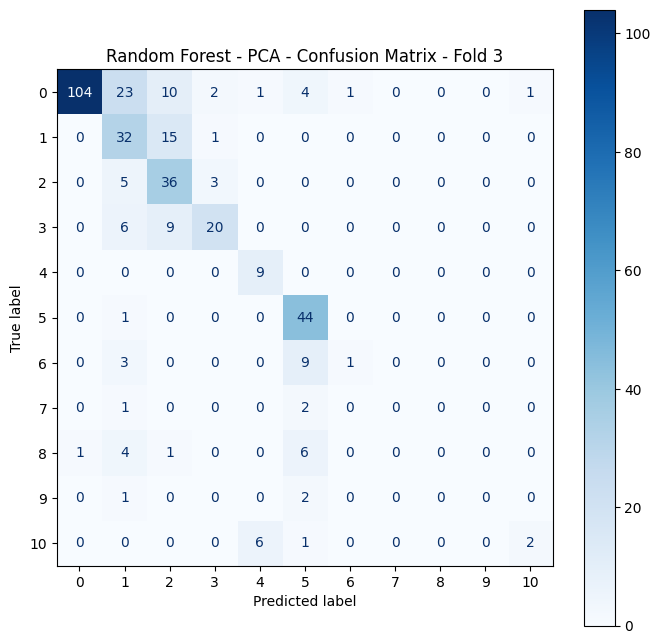

              precision    recall  f1-score     support
0              0.980952  0.705479  0.820717  146.000000
1              0.493671  0.812500  0.614173   48.000000
2              0.545455  0.681818  0.606061   44.000000
3              0.595238  0.714286  0.649351   35.000000
4              0.562500  1.000000  0.720000    9.000000
5              0.767857  0.955556  0.851485   45.000000
6              0.750000  0.230769  0.352941   13.000000
7              0.000000  0.000000  0.000000    3.000000
8              0.000000  0.000000  0.000000   12.000000
9              1.000000  0.333333  0.500000    3.000000
10             0.555556  0.555556  0.555556    9.000000
accuracy       0.702997  0.702997  0.702997    0.702997
macro avg      0.568294  0.544482  0.515480  367.000000
weighted avg   0.733282  0.702997  0.693689  367.000000


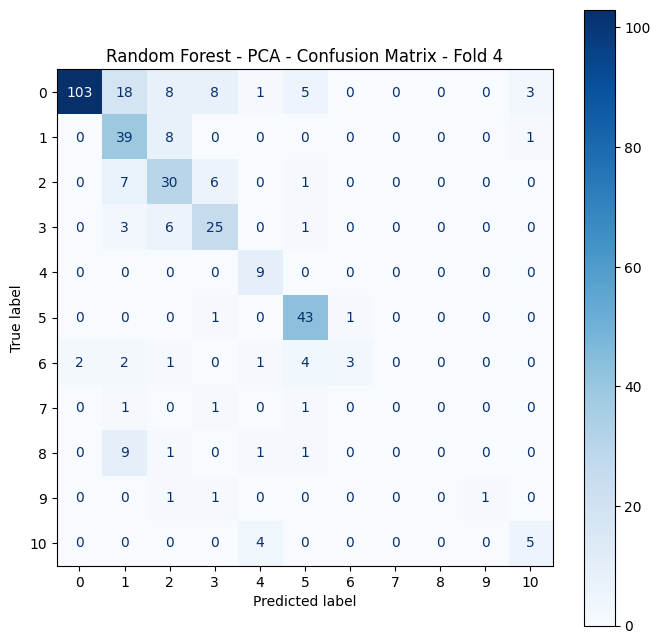

              precision    recall  f1-score    support
0              0.957895  0.623288  0.755187  146.00000
1              0.415584  0.666667  0.512000   48.00000
2              0.575758  0.863636  0.690909   44.00000
3              0.727273  0.685714  0.705882   35.00000
4              0.562500  1.000000  0.720000    9.00000
5              0.614286  0.955556  0.747826   45.00000
6              1.000000  0.230769  0.375000   13.00000
7              0.000000  0.000000  0.000000    3.00000
8              0.000000  0.000000  0.000000   12.00000
9              0.000000  0.000000  0.000000    3.00000
10             0.666667  0.444444  0.533333    9.00000
accuracy       0.664850  0.664850  0.664850    0.66485
macro avg      0.501815  0.497279  0.458194  367.00000
weighted avg   0.714697  0.664850  0.653260  367.00000


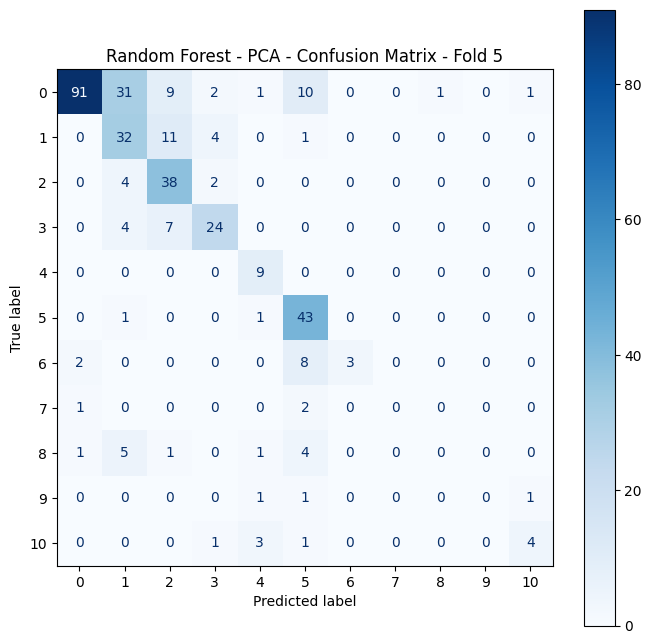

In [17]:
for i in range(len(conf_matrices)):
    print(report_dict[f"Fold {i}"])
    plot_confusion_matrix(conf_matrices[i], title=f"Random Forest - PCA - Confusion Matrix - Fold {i+1}")
del i